# DataJoint U24 - Workflow DeepLabCut

## Introduction

This notebook gives a brief overview and introduces some useful DataJoint tools to facilitate the exploration.

+ DataJoint needs to be configured before running this notebook, if you haven't done so, refer to the [01-Configure](./01-Configure.ipynb) notebook.
+ If you are familar with DataJoint and the workflow structure, proceed to the next notebook [03-Process](./03-Process.ipynb) directly to run the workflow.
+ For a more thorough introduction of DataJoint functionings, please visit our [general tutorial site](http://codebook.datajoint.io/)

To load the local configuration, we will change the directory to the package root.

In [2]:
import os; from pathlib import Path
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='workflow-deeplabcut', ("Please move to the "
                                                              + "workflow directory")

## Schemas and tables

By importing from `workflow_deeplabcut`, we'll run the activation functions that declare the tables in these schemas. If these tables are already declared, we'll gain access.

In [3]:
import datajoint as dj
from workflow_deeplabcut.pipeline import lab, subject, session, dlc

Connecting cbroz@tutorial-db.datajoint.io:3306


Each module contains a schema object that enables interaction with the schema in the database. For more information abotu managing the upstream tables, see our [session workflow](https://github.com/datajoint/workflow-session). In this case, lab is required because the pipeline adds a `device` table to the lab schema to keep track of camera IDs.

`dj.list_schemas()` lists all schemas a user has access to in the current database

In [19]:
dj.list_schemas()

`<schema>.schema.list_tables()` will provide names for each table in the format used under the hood.

In [8]:
dlc.schema.list_tables()

['video_recording',
 'video_recording__file',
 '#model_training_param_set',
 '#body_part',
 'model',
 'model__body_part',
 'training_task',
 '__model_evaluation',
 'pose_estimation_task',
 '__model_training',
 '__pose_estimation',
 '__pose_estimation__body_part_position']

`dj.Diagram()` plots tables and dependencies in a schema

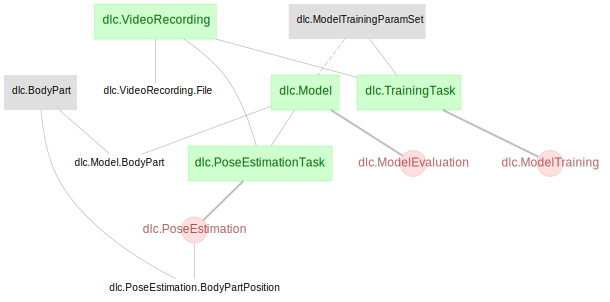

In [9]:
dj.Diagram(dlc)

### Table tiers 
- **Manual table**: green box, manually inserted table, expect new entries daily, e.g. Subject, ProbeInsertion.  
- **Lookup table**: gray box, pre inserted table, commonly used for general facts or parameters. e.g. Strain, ClusteringMethod, ClusteringParamSet.  
- **Imported table**: blue oval, auto-processing table, the processing depends on the importing of external files. e.g. process of Clustering requires output files from kilosort2.  
- **Computed table**: red circle, auto-processing table, the processing does not depend on files external to the database, commonly used for     
- **Part table**: plain text, as an appendix to the master table, all the part entries of a given master entry represent a intact set of the master entry. e.g. Unit of a CuratedClustering.

### Dependencies

- **One-to-one primary**: thick solid line, share the exact same primary key, meaning the child table inherits all the primary key fields from the parent table as its own primary key.     
- **One-to-many primary**: thin solid line, inherit the primary key from the parent table, but have additional field(s) as part of the primary key as well
- **secondary dependency**: dashed line, the child table inherits the primary key fields from parent table as its own secondary attribute.

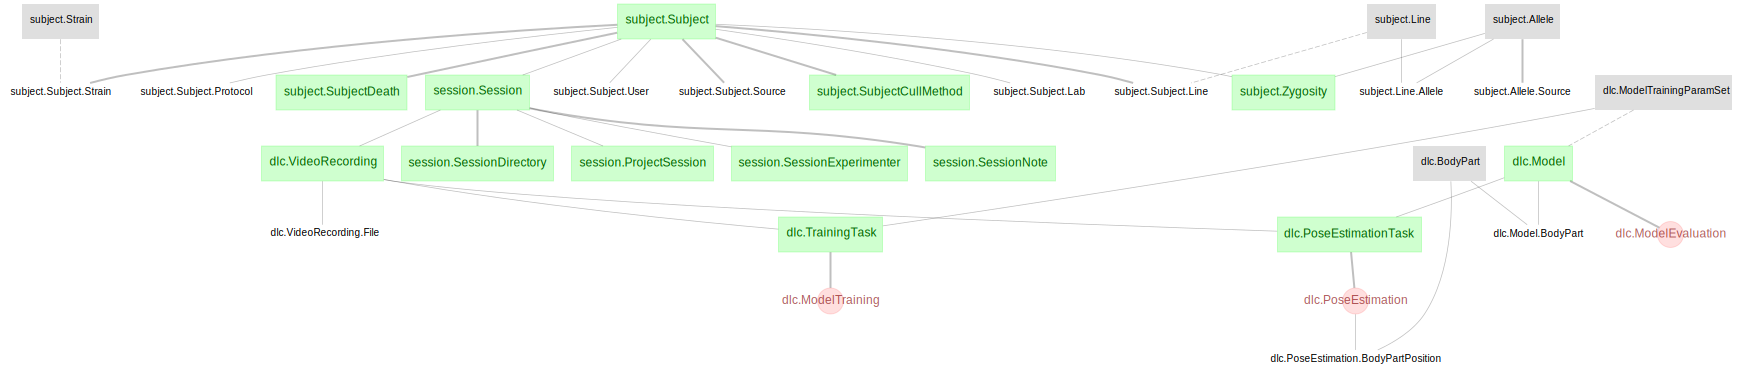

In [11]:
# plot diagram of tables in multiple schemas
dj.Diagram(subject) + dj.Diagram(session) + dj.Diagram(dlc)

In [7]:
lab.schema.list_tables()

['#device',
 '#user_role',
 '#skull_reference',
 '#lab',
 'equipment',
 'equipment__ca_img_equipment',
 'equipment__ephys_equipment',
 '#user',
 '#protocol_type',
 '#source',
 '#project',
 '#location',
 '#lab_membership',
 '#protocol',
 '#project__keywords',
 '#project__publication',
 '#project__sourcecode',
 'project_keywords',
 'project_publication',
 'project_source_code',
 'project_user']

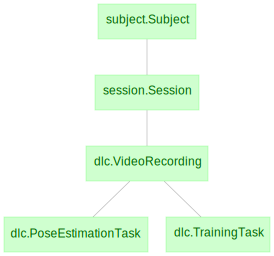

In [9]:
# plot diagram of selected tables and schemas
(dj.Diagram(subject.Subject) + dj.Diagram(session.Session) 
 + dj.Diagram(dlc.VideoRecording) + dj.Diagram(dlc.TrainingTask)
 + dj.Diagram(dlc.PoseEstimationTask)) 

In [ ]:
# preview columns and contents in a table
dlc.VideoRecording.File()

subject,session_datetime,camera_id,recording_id,"file_path filepath of video, relative to root data directory"
subject5,2020-04-15 11:16:38,1,3,Reaching-Mackenzie-2018-08-30/videos/reachingvideo1.avi
subject6,2021-06-02 14:04:22,1,1,openfield-Pranav-2018-10-30/videos/m3v1mp4.mp4
subject6,2021-06-03 14:04:22,1,2,openfield-Pranav-2018-10-30/videos/m3v1mp4-copy.mp4


`describe()` shows table definition with foreign key references

In [13]:
dlc.TrainingTask.describe()

# Specification for a DLC model training instance
-> dlc.VideoRecording
-> dlc.ModelTrainingParamSet
training_id          : int                          
---
model_prefix=""      : varchar(32)                  
project_path=""      : varchar(255)                 # DLC's project_path in config relative to root



'# Specification for a DLC model training instance\n-> dlc.VideoRecording\n-> dlc.ModelTrainingParamSet\ntraining_id          : int                          \n---\nmodel_prefix=""      : varchar(32)                  \nproject_path=""      : varchar(255)                 # DLC\'s project_path in config relative to root\n'

`heading` shows attribute definitions regardless of foreign key references

In [14]:
dlc.Model.heading

# 
model_name           : varchar(64)                  # user-friendly model name
---
task                 : varchar(32)                  # task in the config yaml
date                 : varchar(16)                  # date in the config yaml
iteration            : int                          # iteration/version of this model
snapshotindex        : int                          # which snapshot for prediction (if -1, latest)
shuffle              : int                          # which shuffle of the training dataset
trainingsetindex     : int                          # which training set fraction to generate model
scorer               : varchar(64)                  # scorer/network name - DLC's GetScorerName()
config_template      : longblob                     # dictionary of the config for analyze_videos()
project_path         : varchar(255)                 # DLC's project_path in config relative to root
dlc_version          : varchar(8)                   # keeps the deeplabcut version

## Other Elements installed with the workflow

[`lab`](https://github.com/datajoint/element-lab): lab management related information, such as Lab, User, Project, Protocol, Source.

In [ ]:
dj.Diagram(lab)

[`subject`](https://github.com/datajoint/element-animal): general animal information, User, Genetic background, Death etc.

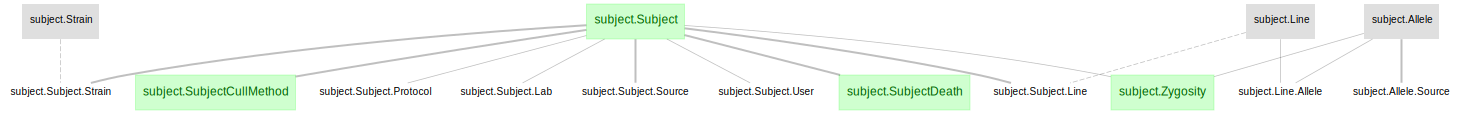

In [12]:
dj.Diagram(subject)

In [13]:
subject.Subject.describe();

# Animal Subject
subject              : varchar(32)                  
---
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



[`session`](https://github.com/datajoint/element-session): General information of experimental sessions.

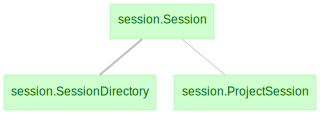

In [14]:
dj.Diagram(session)

In [15]:
session.Session.describe();

-> subject.Subject
session_datetime     : datetime(3)                  



## Summary and next step

- This notebook introduced the overall structures of the schemas and tables in the workflow and relevant tools to explore the schema structure and table definitions.

- The [next notebook](./03-Process.ipynb) will introduce the detailed steps to run through `workflow-deeplabcut`.